In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import svm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import seaborn as sns
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# TODO

* CLean up this notebook overall

* Be more systematic -  Add one predictor at a time and see if we can do better then just using Sex? 
 
* Consider also interactions, especially with respect to sex since it seems to dominate.

* Use SKlearn to cross validate 

In [96]:

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [97]:
train_data["Pclass"] = train_data["Pclass"].astype("category")
 

## Look at the data first

In [98]:
def plot_survival_rate(col):
    survival  = train_data[["Survived",col]].groupby(col).mean().reset_index()
    sns.barplot(data=survival,x=col, y='Survived')

First lets consider Age

It's not at all obvious what is going on here, lets try cutting the age into quantiles

In [99]:
train_data["AgeCat"] = pd.qcut(train_data["Age"],5, labels = ["VY","Y","M","A","O"])

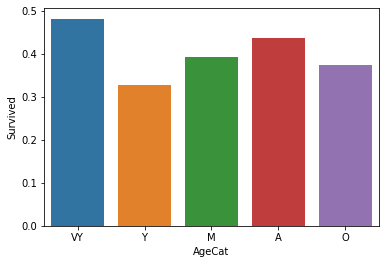

In [100]:
plot_survival_rate('AgeCat')

Difficult see much of a useful trend with age. Maybe with less categories, and split evenly not on quantiles. Looks like we could play with these split points a lot, but the general trend argues for just fitting on age after all

In [101]:
train_data["AgeCat"] = pd.cut(train_data["Age"],[0,10,60,100], labels = ["Y","M","O"])

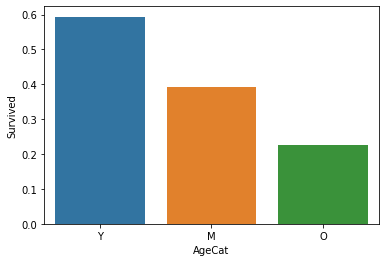

In [102]:
plot_survival_rate("AgeCat")

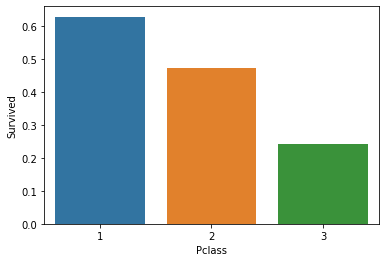

In [103]:
plot_survival_rate('Pclass')

Passenger class certainly matters

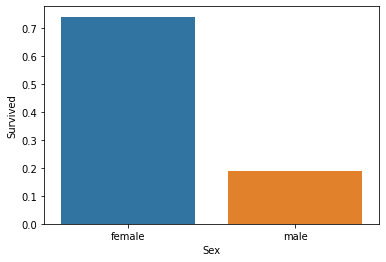

In [104]:
plot_survival_rate('Sex')

As does sex

In [105]:
train_data[['Sex','Survived','Pclass']].groupby(['Sex','Pclass']).mean()

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

So even controlling for sex Pclass matters

In [106]:
train_data[['Sex','Survived','AgeCat']].groupby(['Sex','AgeCat']).mean()

Survived
Sex    AgeCat          
female Y       0.612903
       M       0.770925
       O       1.000000
male   Y       0.575758
       M       0.179551
       O       0.105263

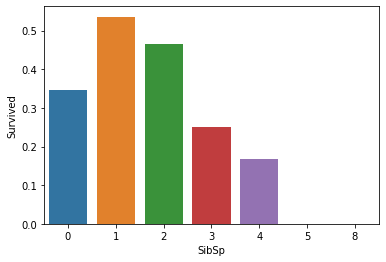

In [107]:
plot_survival_rate('SibSp')

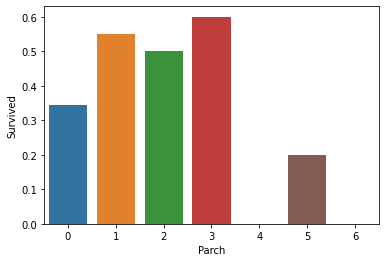

In [108]:
plot_survival_rate('Parch')

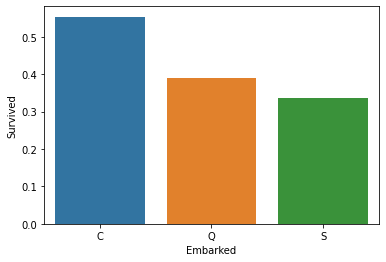

In [109]:
plot_survival_rate('Embarked')

In [110]:
train_data['Family'] = train_data['Parch']+ train_data['SibSp']

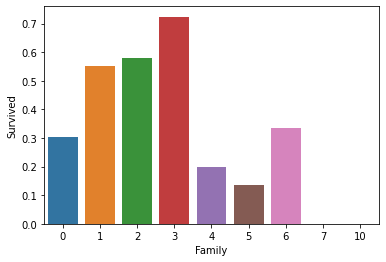

In [111]:
plot_survival_rate('Family')

In [112]:
train_data['solo'] = train_data['Family'] == 0

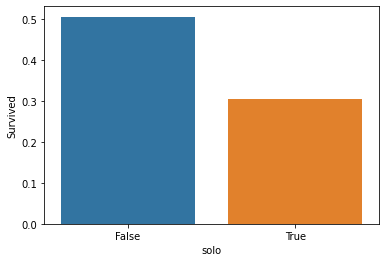

In [113]:
plot_survival_rate('solo')

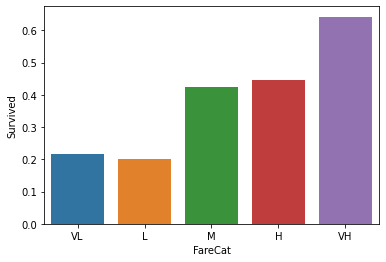

In [114]:
train_data["FareCat"] = pd.qcut(train_data["Fare"],5, labels = ["VL","L","M","H","VH"])
plot_survival_rate('FareCat')

From this we see that Fare is a possible strong predictor, as is class, but these are both highly correlated. We should probably only include one.  Also to include are SibSp and Sex.  We can cross validate with and without Age to see if it adds anything.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

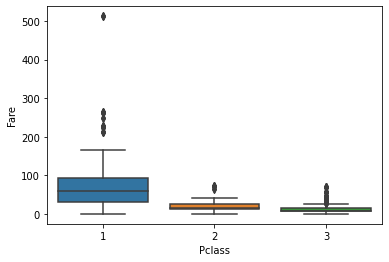

In [115]:
sns.boxplot(x='Pclass', y= 'Fare', data=train_data)

This makes me think that fare has abit  more detail.

<AxesSubplot:xlabel='Age', ylabel='Sex'>

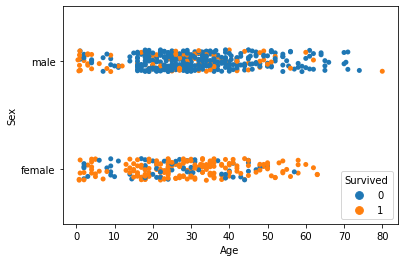

In [116]:
sns.stripplot(x='Age', y='Sex', hue='Survived',data=train_data,jitter=True)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

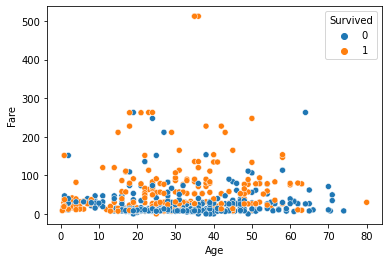

In [15]:
sns.scatterplot(x='Age', y= 'Fare', hue = 'Survived', data = train_data)

## Try to fit a logistic regression

Examine missing data

In [117]:
train_data.apply(lambda x:np.sum(x.isna()))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
AgeCat         177
Family           0
solo             0
FareCat          0
dtype: int64

We dont care abotu Cabin, but we will want to fix teh age issue

In [118]:
mean_age = np.mean(train_data["Age"])
mean_age

29.69911764705882

For futre testing with age, i am going to put in the mean value for fitting

In [119]:
train_data.loc[train_data["Age"].isna(),"Age"] =  mean_age
train_data["AgeCat"] = pd.cut(train_data["Age"],[0,10,60,100], labels = ["Y","M","O"])

In [120]:
train_data[["Embarked","PassengerId"]].groupby("Embarked").count()

,PassengerId
Embarked,
C,168
Q,77
S,644


S is most common

In [121]:
train_data.loc[train_data["Embarked"].isna(),"Embarked"] =  'S'

In [122]:
# Zero model
formula0 = "Survived ~ Sex"
mod0 = smf.glm(formula=formula0, data=train_data, family=sm.families.Binomial()).fit()
print(mod0.summary())
np.mean((mod0.predict() > .5) == (train_data["Survived"] ==1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      889
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -458.90
Date:                Thu, 22 Sep 2022   Deviance:                       917.80
Time:                        05:19:48   Pearson chi2:                     891.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2605
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0566      0.129      8.191      

0.7867564534231201

Se We need to do better then 78.7% on teh training data!

This is the best so far using cross validation below. Not stellar by any means

In [123]:
formula1 = "Survived ~ Sex + Family + Age + I(Age**2) + Pclass + Pclass:Sex + Age:Sex"
mod1 = smf.glm(formula=formula1, data=train_data, family=sm.families.Binomial()).fit()
print(mod1.summary())
score = np.mean((mod1.predict() > .5) == (train_data["Survived"] ==1))
print(f"Score: {score}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      881
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -373.60
Date:                Thu, 22 Sep 2022   Deviance:                       747.20
Time:                        05:19:52   Pearson chi2:                     941.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3893
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Cross Validation (to be cleaned)

Lets look at cross validation. For this we will use sklearn's tools.

In [127]:
formula1

'Survived ~ Sex + Family + Age + I(Age**2) + Pclass + Pclass:Sex + Age:Sex'

In [124]:
outcome, predictors = dmatrices(formula1, train_data, return_type="matrix")
skmod = make_pipeline(StandardScaler(), LogisticRegression())
skmod.fit(predictors, np.ravel(outcome))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [125]:
np.mean(skmod.predict(predictors) == np.ravel(outcome))

array(0.81481481)

Ok so sklearn gets the same results for that formula, now to cross validate. 


## Cross validation

Here i tried various formula and interactions lookign for best cross validaition score.

In [126]:
formulaTest = "Survived ~ Sex + Family + Age + I(Age**2) + Pclass + Pclass:Sex + Age:Sex"
#formulaTest = "Survived ~ Sex + Family + Age  + I(Age**2) + Pclass + Pclass:Sex + Age:Sex"
outcome, predictors = dmatrices(formulaTest, train_data, return_type="matrix")
scores = cross_val_score(skmod,predictors,np.ravel(outcome),cv=10)
(np.mean(scores),np.std(scores))

(0.8125343320848938, 0.03157318920705796)

Trying out different values of the regulator

In [155]:
formulaTest = "Survived ~ Sex + Family + Age + I(Age**2) + Pclass + Pclass:Sex + Age:Sex"
#formulaTest = "Survived ~ Sex + Family + Age  + I(Age**2) + Pclass + Pclass:Sex + Age:Sex"
outcome, predictors = dmatrices(formulaTest, train_data, return_type="matrix")

def compute_score_reg(penalty, c):
    pipe=make_pipeline(StandardScaler(), LogisticRegression(penalty = penalty, C=c, solver='liblinear'))
    scores = cross_val_score(pipe,predictors,np.ravel(outcome),cv=10)
    return np.mean(scores)




In [156]:
[compute_score_reg("l2",c) for c in [.01,.05,.1,.5,1.0,10.0,100.0]]

[0.7889762796504369,
 0.8047191011235955,
 0.8035955056179775,
 0.8159051186017479,
 0.8125343320848938,
 0.810287141073658,
 0.8114107365792759]

In [157]:
[compute_score_reg("l1",c) for c in [.01,.05,.1,.5,1.0,10.0,100.0]]

[0.786729088639201,
 0.7833832709113608,
 0.8047315855181024,
 0.810287141073658,
 0.8125343320848938,
 0.810287141073658,
 0.8114107365792759]

Regularization doesnt seem to help here in any significant way

Also compare 0 model

In [27]:
outcome, predictors = dmatrices(formula0, train_data, return_type="matrix")
scores = cross_val_score(skmod,predictors,np.ravel(outcome),cv=10)
np.mean(scores)

0.786729088639201

# TEST DATA

In [88]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [89]:
test_data.apply(lambda x:np.sum(x.isna()))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [90]:
np.mean(test_data["Age"])

30.272590361445783

In [91]:
test_data['Family'] = test_data['Parch']+ test_data['SibSp']
test_data.loc[test_data["Age"].isna(),"Age"] =  mean_age
test_data.loc[test_data["Embarked"].isna(),"Embarked"] =  'S'

For first try i am going to just use model 1

In [92]:
test_data['Survived'] = (mod1.predict(test_data) > 0.5).astype(int)

In [93]:
result = test_data[['PassengerId','Survived']]

In [94]:
result.to_csv('submission.csv',index=False)